In [90]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
from controllers import DeePC
import gym
import mujoco_py
from gym import wrappers
from IPython import display

plt.rcParams["figure.figsize"] = (18,6)

%matplotlib inline
%reload_ext autoreload
%autoreload 

## Data Collection

In [91]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')

"""
    Timestep for InvertedPendelum-v4 is 0.02
"""

obs, info = env.reset()

Tini = 4
n = 4
N = 10
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 70
print(T)
render_collection = False

ud = []
yd = []
i = 0

while i < T:

    # restart loop if data is non-linear
    if np.abs(obs[1]) > 0.1 or np.abs(obs[0]) > 0.1 or np.abs(obs[2]) > 0.15 or np.abs(obs[3]) > 0.15 :
        obs, info = env.reset()
        i = 0
        ud = []
        yd = []

    # Add noise to action and roll sim forward
    action = [obs[1]*2 - np.random.randn()*0.01]
    obs, rew, done, info, _ = env.step(action)
    ud = np.append(ud,action)
    yd = np.append(yd,obs)

    # display gym annimation if requested
    if render_collection:
        plt.title(f"Action {action[0]:.2f} Theta {obs[1]:.2f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    i+=1

env.close()
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

106
yd shape : (424,)   ud shape : (106,)


## Controller Setup

In [92]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_const = np.kron(np.ones(N), np.array([0.2, 0.2, 0.2, 0.2]))
u_const = np.ones(N)*3
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_const, u_constraints=u_const,
    N=N, Tini=Tini, n=n, T=T, p=p, m=m, Q=Q, R=R
)

## Simulation

In [93]:
u_ini = np.zeros(Tini*m)
y_ini = np.zeros(Tini*p)
yT = [*y_ini]
uT = [*u_ini]
ref = np.zeros(N*p)

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
render_solution = False
iter = 0

while iter < 100:

    # Solve for optimal input
    controller.setup(ref=ref, u_ini=u_ini, y_ini=y_ini, lam_g1=100000, lam_g2=10000, lam_y=1000000)
    action = controller.solve(verbose=False)

    # roll simulation forward
    obs,_,done,_,_ = env.step(action)
    yT = np.append(yT, obs)
    uT = np.append(uT, action)
    
    # break from sim if constraints are violated
    if np.abs(obs[1]) > 0.2 or np.abs(obs[0]) > 0.2 or np.abs(obs[2]) > 0.2 or np.abs(obs[3]) > 0.2 : break

    # Render gym env
    if render_solution:
        plt.title(f"Action {action[0]:.2f}, X {obs[0]:.2f}, Theta {obs[1]:.2f} Iter {iter}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    # Reset initial conditions
    u_ini = uT[-Tini:]
    y_ini = yT[-p*Tini:]
    iter += 1


## Visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


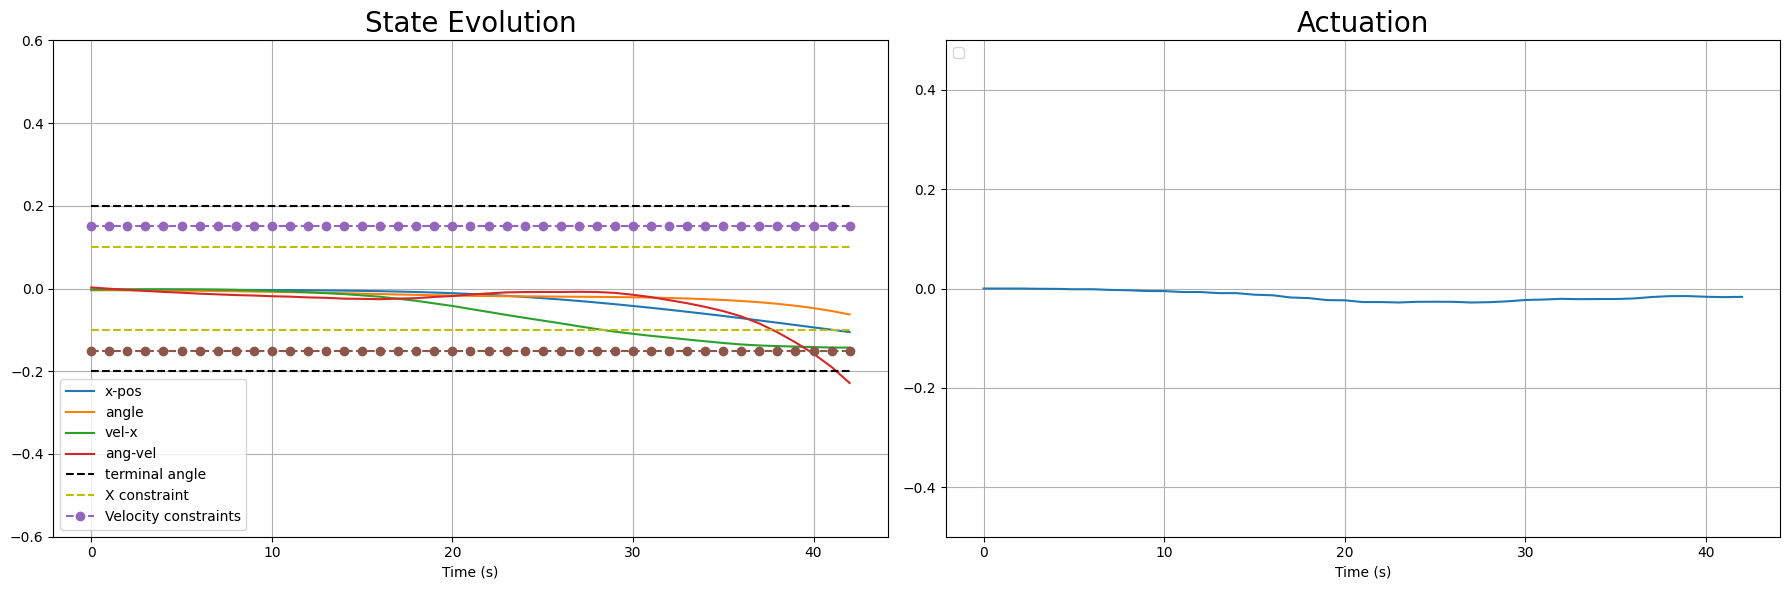

In [94]:
uT = uT[Tini*m:]
yT = yT[Tini*p:]
T = len(uT)
yT = yT.reshape((T,p))
uT = uT.reshape((T,m))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.plot(range(0,T), np.ones(T)*0.1, 'y--', label='X constraint')
plt.plot(range(0,T), -np.ones(T)*0.1, 'y--')
plt.plot(range(0,T), np.ones(T)*0.15, 'o--', label='Velocity constraints')
plt.plot(range(0,T), -np.ones(T)*0.15, 'o--')
plt.legend(loc="lower left")
plt.ylim((-0.6,0.6))
plt.xlabel('Time (s)')
plt.title("State Evolution", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation", fontdict={'fontsize':20})
plt.ylim((-0.5,0.5))
plt.grid('on')
plt.tight_layout()

plt.show()
yT = yT.reshape((T*p,))
